# *SALES FORECASTING DASHBOARD PROJECT*

## Import All Required Libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mysql.connector
from mysql.connector import Error
import warnings
warnings.filterwarnings('ignore')


In [89]:

df = pd.read_csv("C:/Users/monik_vm0vkhl/Desktop/sales-forecasting-dashboard/data/stores_sales_forecasting.csv", encoding='latin-1')

print(f"Total rows: {len(df)}")
print("\nColumns:")
print(df.columns.tolist())


Total rows: 2121

Columns:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [90]:
 # Rename columns to match MySQL table column names
df.columns = df.columns.str.replace(' ', '_')

print(df.columns.tolist())

# Convert Date columns to proper format
df['Order_Date'] = pd.to_datetime(df['Order_Date']).dt.strftime('%Y-%m-%d')
df['Ship_Date'] = pd.to_datetime(df['Ship_Date']).dt.strftime('%Y-%m-%d')


['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub-Category', 'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit']


## SQL CONNECTION & DATA LOADING

In [91]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",      
    password="MtM307@#1Wh", 
    database="sales_forecasting"  # Database name
)

cursor = conn.cursor()

print("Connected to MySQL successfully!")

Connected to MySQL successfully!


In [92]:
query = "SELECT * FROM sales_data"
df_sql = pd.read_sql(query, conn)

df_sql.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
3,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7,0.00,14.17
4,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.18,9,0.20,85.31


In [93]:
# To Load the full sales_data table
df = pd.read_sql("SELECT * FROM sales_data", conn)

print("\n Data Types:")
print(df.dtypes)



 Data Types:
Row_ID             int64
Order_ID          object
Order_Date        object
Ship_Date         object
Ship_Mode         object
Customer_ID       object
Customer_Name     object
Segment           object
Country           object
City              object
State             object
Postal_Code       object
Region            object
Product_ID        object
Category          object
Sub_Category      object
Product_Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object


In [94]:
print("\n Missing Values:")
print(df.isnull().sum())



 Missing Values:
Row_ID           0
Order_ID         0
Order_Date       0
Ship_Date        0
Ship_Mode        0
Customer_ID      0
Customer_Name    0
Segment          0
Country          0
City             0
State            0
Postal_Code      0
Region           0
Product_ID       0
Category         0
Sub_Category     0
Product_Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [95]:
print("\n Summary Statistics:")
print(df.describe())


 Summary Statistics:
            Row_ID        Sales     Quantity     Discount       Profit
count  2121.000000  2121.000000  2121.000000  2121.000000  2121.000000
mean   5041.643564   349.834974     3.785007     0.173923     8.699316
std    2885.740258   503.179147     2.251620     0.181547   136.049323
min       1.000000     1.890000     1.000000     0.000000 -1862.310000
25%    2568.000000    47.040000     2.000000     0.000000   -12.850000
50%    5145.000000   182.220000     3.000000     0.200000     7.770000
75%    7534.000000   435.170000     5.000000     0.300000    33.730000
max    9991.000000  4416.170000    14.000000     0.700000  1013.130000


### Convert Date Columns to DateTime Format

In [96]:
def run_sql_query(query):
    """Safe SQL query with auto-connect/reconnect"""
    conn = None
    cursor = None
    try:
        # Fresh connection each time (fixes 2055 error)
        conn = mysql.connector.connect(
            host="localhost",
            user="root",      
            password="MtM307@#1Wh", 
            database="sales_forecasting"
        )
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(results, columns=columns)
        print(" Query executed successfully!")
        return df
    except Error as e:
        print(f" SQL Error: {e}")
        return pd.DataFrame()
    finally:
        if cursor:
            cursor.close()
        if conn and conn.is_connected():
            conn.close()
            print(" Connection closed safely")


In [97]:
# Convert Order_Date and Ship_Date to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'])

print("Date columns converted to DateTime format!")
print(f"\nOrder Date Range: {df['Order_Date'].min()} to {df['Order_Date'].max()}")

Date columns converted to DateTime format!

Order Date Range: 2014-01-06 00:00:00 to 2017-12-30 00:00:00


### SQL QUERIES FOR ANALYSIS

In [98]:
# Help function to run SQL queries
def run_sql_query(query):
    """Execute SQL query and return results as DataFrame"""
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    return pd.DataFrame(results, columns=columns)

## Total Sales by Category

In [99]:
query1 = """
SELECT 
    Category,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    COUNT(*) AS Total_Orders,
    ROUND(AVG(Sales), 2) AS Avg_Order_Value
FROM sales_data
GROUP BY Category
ORDER BY Total_Sales DESC;
"""

category_df = run_sql_query(query1)
print(category_df)


    Category Total_Sales  Total_Orders Avg_Order_Value
0  Furniture   741999.98          2121          349.83


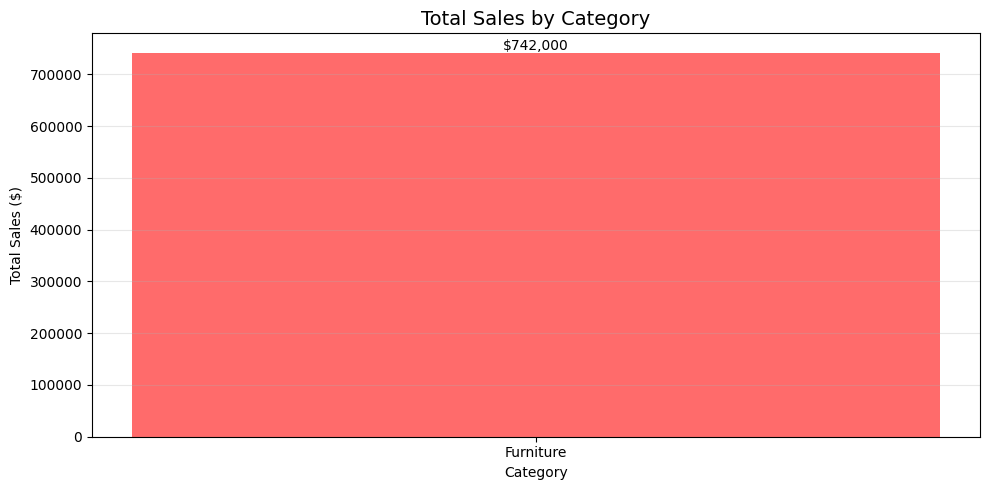

In [100]:
#To visualize
plt.figure(figsize=(10, 5))
plt.bar(category_df['Category'], category_df['Total_Sales'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Total Sales by Category', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Total Sales ($)')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(category_df['Total_Sales']):
    plt.text(i, v + 5000, f"${v:,.0f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

### Sales by Segment

In [101]:
query2 = """
SELECT 
    Segment,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    COUNT(*) AS Total_Orders
FROM sales_data
GROUP BY Segment
ORDER BY Total_Sales DESC;
"""

segment_df = run_sql_query(query2)
print(segment_df)

       Segment Total_Sales  Total_Orders
0     Consumer   391049.43          1113
1    Corporate   229019.83           646
2  Home Office   121930.72           362


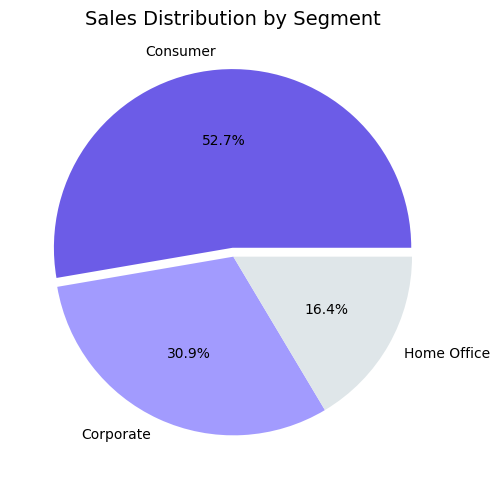

In [102]:
# To visualize
plt.figure(figsize=(8, 5))
colors = ['#6C5CE7', '#A29BFE', '#DFE6E9']
plt.pie(segment_df['Total_Sales'], labels=segment_df['Segment'], autopct='%1.1f%%', 
        colors=colors, explode=(0.05, 0, 0))
plt.title('Sales Distribution by Segment', fontsize=14)
plt.tight_layout()
plt.show()

### Sales by Region

In [103]:
query3 = """
SELECT 
    Region,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    ROUND(SUM(Profit), 2) AS Total_Profit,
    ROUND((SUM(Profit) / SUM(Sales)) * 100, 2) AS Profit_Margin_Percent
FROM sales_data
GROUP BY Region
ORDER BY Total_Sales DESC;
"""

region_df = run_sql_query(query3)
print(region_df)

    Region Total_Sales Total_Profit Profit_Margin_Percent
0     West   252612.87     11504.92                  4.55
1     East   208291.17      3046.20                  1.46
2  Central   163797.26     -2871.10                 -1.75
3    South   117298.68      6771.23                  5.77


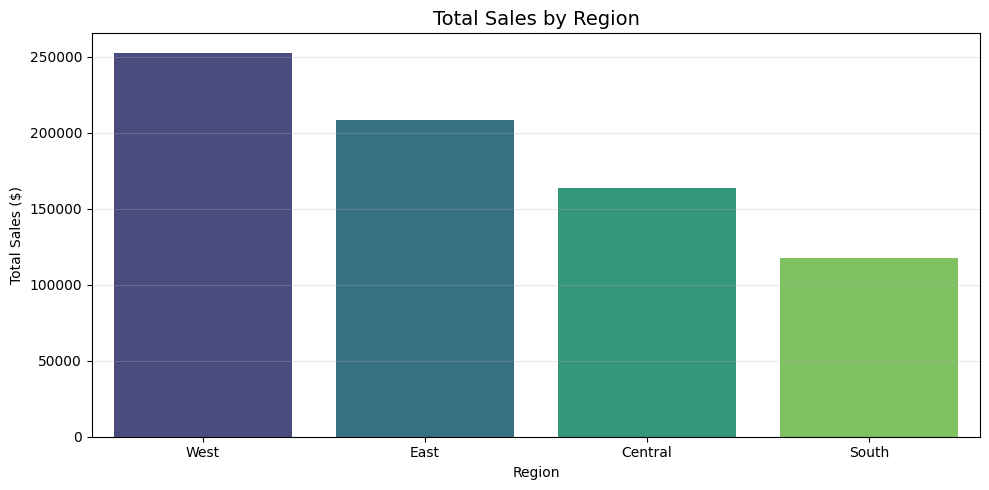

In [104]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Region', y='Total_Sales', data=region_df, palette='viridis')
plt.title('Total Sales by Region', fontsize=14)
plt.ylabel('Total Sales ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Top 10 Cities by Sales

In [105]:
query4 = """
SELECT 
    City,
    State,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    ROUND(SUM(Profit), 2) AS Total_Profit
FROM sales_data
GROUP BY City, State
ORDER BY Total_Sales DESC
LIMIT 10;
"""

top_cities_df = run_sql_query(query4)
print(top_cities_df)

            City         State Total_Sales Total_Profit
0  New York City      New York    75691.03      5306.73
1    Los Angeles    California    54000.06      3071.60
2        Seattle    Washington    40995.88      6208.85
3   Philadelphia  Pennsylvania    36495.54     -6827.11
4  San Francisco    California    36357.32      1491.36
5        Houston         Texas    23183.20     -3404.83
6      San Diego    California    20031.24      1106.35
7        Detroit      Michigan    16364.01      3332.69
8        Chicago      Illinois    12495.24     -3516.47
9         Dallas         Texas     7306.90     -2023.17


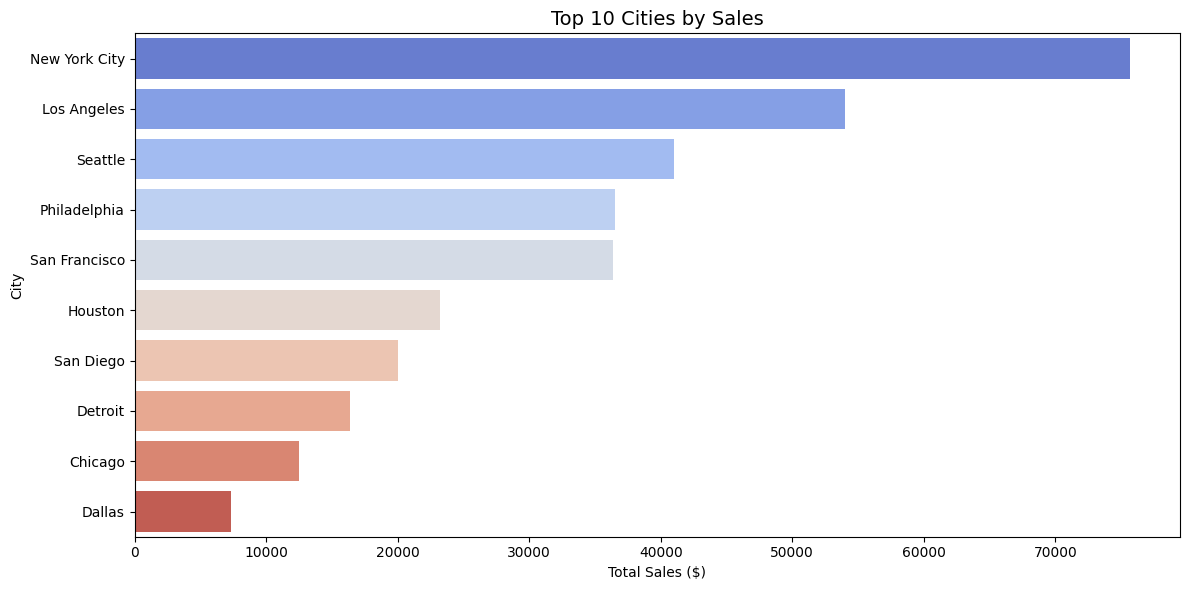

In [106]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Sales', y='City', data=top_cities_df, palette='coolwarm')
plt.title('Top 10 Cities by Sales', fontsize=14)
plt.xlabel('Total Sales ($)')
plt.ylabel('City')
plt.tight_layout()
plt.show()

### Monthly Sales Trend

In [107]:
query5 = """
SELECT 
    DATE_FORMAT(Order_Date, '%Y-%m') AS Year_Mon,
    ROUND(SUM(Sales), 2) AS Monthly_Sales,
    COUNT(*) AS Total_Orders
FROM sales_data
GROUP BY DATE_FORMAT(Order_Date, '%Y-%m')
ORDER BY Year_Mon;
"""

monthly_df = run_sql_query(query5)
print(monthly_df)

   Year_Mon Monthly_Sales  Total_Orders
0   2014-01       6242.53            20
1   2014-02       1839.66             7
2   2014-03      14573.98            33
3   2014-04       7944.83            26
4   2014-05       6912.80            24
5   2014-06      13206.12            30
6   2014-07      10821.07            33
7   2014-08       7320.35            24
8   2014-09      23816.48            56
9   2014-10      12304.24            32
10  2014-11      21564.86            62
11  2014-12      30645.97            74
12  2015-01      11739.93            15
13  2015-02       3134.37            11
14  2015-03      12499.79            28
15  2015-04      10475.71            33
16  2015-05       9374.97            30
17  2015-06       7714.18            26
18  2015-07      13674.42            40
19  2015-08       9638.59            32
20  2015-09      26273.03            60
21  2015-10      12026.64            36
22  2015-11      30880.80            77
23  2015-12      23085.83            64


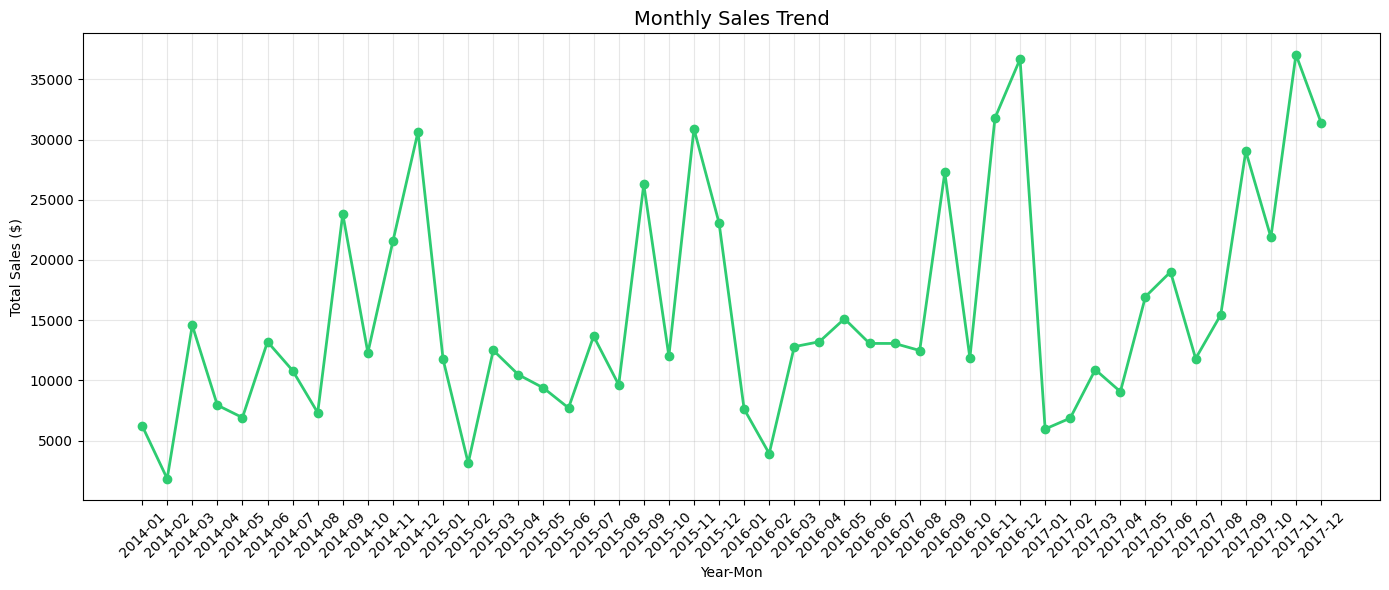

In [108]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_df['Year_Mon'], monthly_df['Monthly_Sales'], marker='o', 
         color='#2ECC71', linewidth=2)
plt.title('Monthly Sales Trend', fontsize=14)
plt.xlabel('Year-Mon')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Top 10 Customers by Sales

In [109]:
query6 = """
SELECT 
    Customer_ID,
    Customer_Name,
    Segment,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    ROUND(SUM(Profit), 2) AS Total_Profit
FROM sales_data
GROUP BY Customer_ID, Customer_Name, Segment
ORDER BY Total_Sales DESC
LIMIT 10;
"""

top_customers_df = run_sql_query(query6)
print(top_customers_df)


  Customer_ID    Customer_Name    Segment Total_Sales Total_Profit
0    SV-20365      Seth Vernon   Consumer     8332.09       688.40
1    JE-15715       Joe Elijah   Consumer     6920.14       968.08
2    PF-19120     Peter Fuller   Consumer     6837.34       117.01
3    CJ-12010  Caroline Jumper   Consumer     6267.19      -494.91
4    GT-14710        Greg Tran   Consumer     6219.26       268.60
5    LA-16780  Laura Armstrong  Corporate     5387.39      1146.49
6    TP-21415     Tom Prescott   Consumer     4899.11      -621.94
7    NP-18700       Nora Preis   Consumer     4839.66       176.77
8    BB-11545    Brenda Bowman  Corporate     4768.50       770.14
9    BD-11320   Bill Donatelli   Consumer     4513.12       805.98


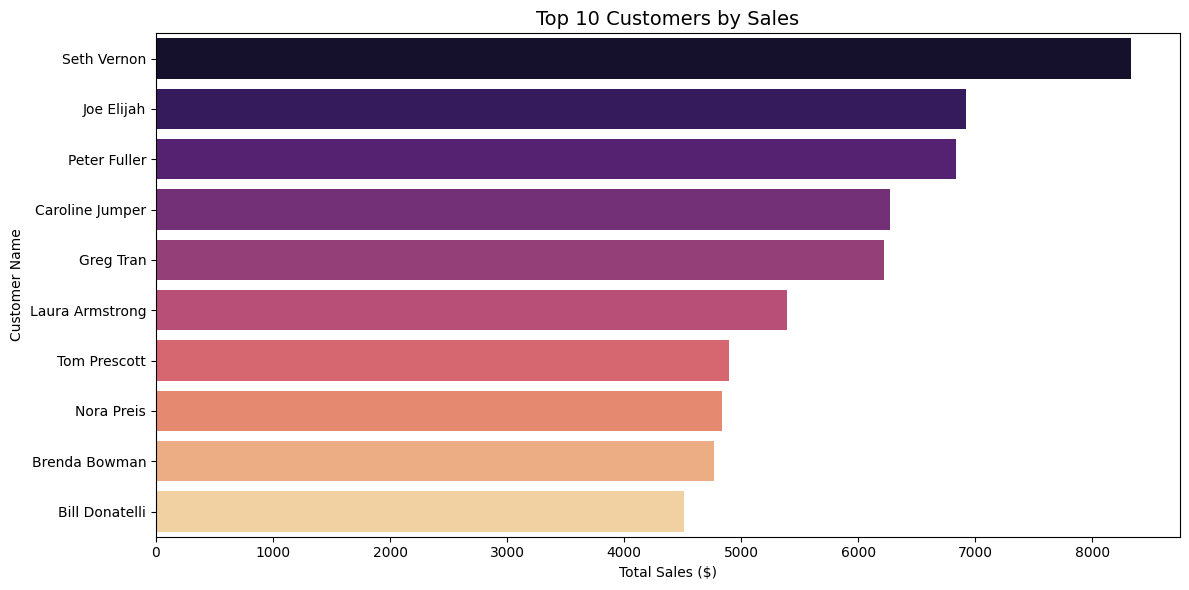

In [110]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Sales', y='Customer_Name', data=top_customers_df, palette='magma')
plt.title('Top 10 Customers by Sales', fontsize=14)
plt.xlabel('Total Sales ($)')
plt.ylabel('Customer Name')
plt.tight_layout()
plt.show()

### Sales by Ship Mode

In [111]:
query7 = """
SELECT 
    Ship_Mode,
    COUNT(*) AS Total_Shipments,
    ROUND(AVG(DATEDIFF(Ship_Date, Order_Date)), 1) AS Avg_Shipping_Days
FROM sales_data
GROUP BY Ship_Mode
ORDER BY Total_Shipments DESC;
"""

ship_df = run_sql_query(query7)
print(ship_df)

        Ship_Mode  Total_Shipments Avg_Shipping_Days
0  Standard Class             1248               5.0
1    Second Class              427               3.3
2     First Class              327               2.1
3        Same Day              119               0.0


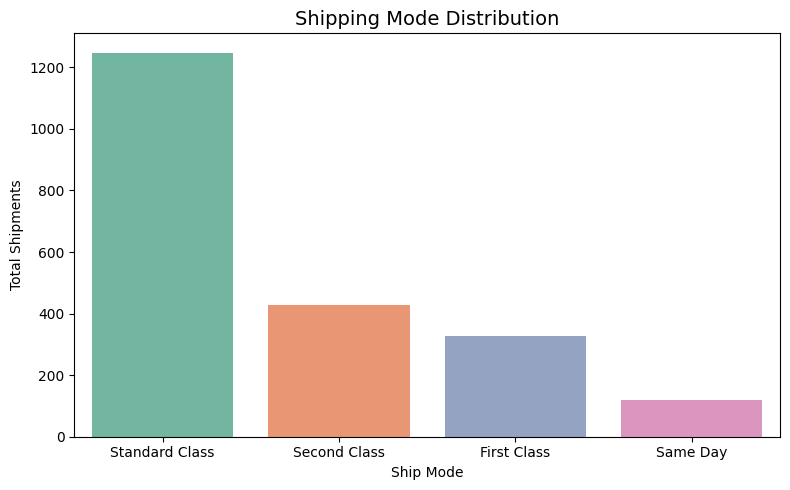

In [112]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Ship_Mode', y='Total_Shipments', data=ship_df, palette='Set2')
plt.title('Shipping Mode Distribution', fontsize=14)
plt.xlabel('Ship Mode')
plt.ylabel('Total Shipments')
plt.tight_layout()
plt.show()

### Discount & Profit Analysis

In [113]:
query8 = """
SELECT 
    CASE 
        WHEN Discount > 0 THEN 'With Discount'
        ELSE 'No Discount'
    END AS Discount_Status,
    COUNT(*) AS Total_Orders,
    ROUND(SUM(Sales), 2) AS Total_Sales,
    ROUND(SUM(Profit), 2) AS Total_Profit,
    ROUND(AVG(Profit), 2) AS Avg_Profit
FROM sales_data
GROUP BY Discount_Status;
"""

discount_df = run_sql_query(query8)
print(discount_df)

  Discount_Status  Total_Orders Total_Sales Total_Profit Avg_Profit
0     No Discount           836   256025.27     58133.16      69.54
1   With Discount          1285   485974.71    -39681.91     -30.88


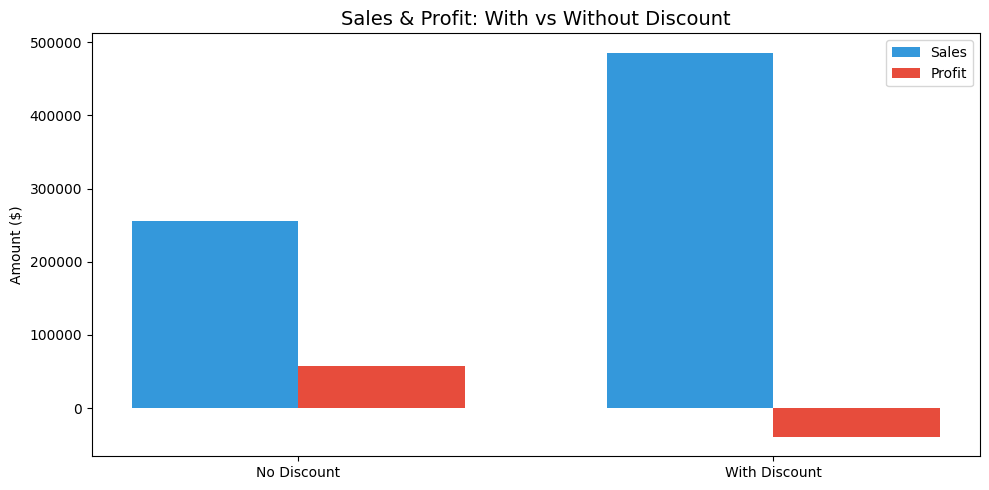

In [114]:
plt.figure(figsize=(10, 5))
x = np.arange(len(discount_df['Discount_Status']))
width = 0.35
plt.bar(x - width/2, discount_df['Total_Sales'], width, label='Sales', color='#3498DB')
plt.bar(x + width/2, discount_df['Total_Profit'], width, label='Profit', color='#E74C3C')
plt.xticks(x, discount_df['Discount_Status'])
plt.title('Sales & Profit: With vs Without Discount', fontsize=14)
plt.ylabel('Amount ($)')
plt.legend()
plt.tight_layout()
plt.show()

In [115]:
# KPI Summary

total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
total_orders = len(df)
avg_order_value = df['Sales'].mean()

print(f"\n Total Sales: ${total_sales:,.2f}")
print(f" Total Profit: ${total_profit:,.2f}")
print(f" Total Orders: {total_orders:,}")
print(f" Average Order Value: ${avg_order_value:,.2f}")


 Total Sales: $741,999.98
 Total Profit: $18,451.25
 Total Orders: 2,121
 Average Order Value: $349.83


#  FEATURE ENGINEERING FOR MODEL

### Prepare Data for Linear Regression Model

In [116]:
# Aggregate data at daily level for modeling
# This creates one row per day with total sales, quantity, profit, etc.

df_daily = df.groupby('Order_Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'
}).reset_index()


In [117]:
# Add time-based features
df_daily['Year'] = df_daily['Order_Date'].dt.year
df_daily['Month'] = df_daily['Order_Date'].dt.month
df_daily['Day'] = df_daily['Order_Date'].dt.day
df_daily['DayOfWeek'] = df_daily['Order_Date'].dt.dayofweek
df_daily['WeekOfYear'] = df_daily['Order_Date'].dt.isocalendar().week

print("Daily aggregated data created!")
print(f"\nShape: {df_daily.shape}")
print("\nSample Data:")
df_daily.head(10)

Daily aggregated data created!

Shape: (889, 10)

Sample Data:


,Order_Date,Sales,Quantity,Profit,Discount,Year,Month,Day,DayOfWeek,WeekOfYear
0,2014-01-06,2573.82,9,746.41,0.000,2014,1,6,0,2
1,2014-01-07,76.73,3,-53.71,0.600,2014,1,7,1,2
2,2014-01-10,51.94,1,21.30,0.000,2014,1,10,4,2
3,2014-01-11,9.94,2,3.08,0.000,2014,1,11,5,2
4,2014-01-13,879.94,9,91.28,0.075,2014,1,13,0,3
5,2014-01-14,61.96,4,-53.29,0.500,2014,1,14,1,3
6,2014-01-16,127.10,6,28.60,0.200,2014,1,16,3,3
7,2014-01-19,181.47,5,-320.60,0.700,2014,1,19,6,3
8,2014-01-20,1413.51,15,276.52,0.000,2014,1,20,0,4
9,2014-01-21,25.25,3,4.10,0.200,2014,1,21,1,4


In [118]:
monthly_sales = (
    df
    .groupby(df['Order_Date'].dt.to_period('M'))
    .agg({
        'Sales': 'sum',
        'Quantity': 'sum',
        'Profit': 'sum'
    })
    .reset_index()
)

monthly_sales['Order_Date'] = monthly_sales['Order_Date'].astype(str)
monthly_sales.columns = [
    'Year_Month',
    'Monthly_Sales',
    'Monthly_Quantity',
    'Monthly_Profit'
]

monthly_sales.head()

,Year_Month,Monthly_Sales,Monthly_Quantity,Monthly_Profit
0,2014-01,6242.53,70,805.46
1,2014-02,1839.66,23,120.69
2,2014-03,14573.98,131,-1128.65
3,2014-04,7944.83,81,554.37
4,2014-05,6912.80,97,-349.86


### BUILD LINEAR REGRESSION MODEL

In [119]:
# Features: Quantity, Profit, Discount, Month, Day, DayOfWeek
# Target: Sales

X = df_daily[['Quantity', 'Profit', 'Discount', 'Month', 'Day', 'DayOfWeek']]
y = df_daily['Sales']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (889, 6)
Target (y) shape: (889,)


In [120]:
# Split Data into Training and Testing Sets
# 80% for training, 20% for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData Split:")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

print("\nModel trained successfully!")

# Display Model Coefficients
print("\nModel Coefficients:")
print("-" *40)
for feature, coef in zip(X.columns, model.coef_):
    print(f"   {feature}: {coef:.4f}")
print(f"   Intercept: {model.intercept_:.4f}")



Data Split:
   Training samples: 711
   Testing samples: 178

Model trained successfully!

Model Coefficients:
----------------------------------------
   Quantity: 101.1493
   Profit: 0.6929
   Discount: 156.9801
   Month: 6.3660
   Day: 2.5189
   DayOfWeek: -9.8234
   Intercept: -184.9335


###  MODEL EVALUATION

In [121]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance Metrics:")
print("-" * 40)
print(f"   R² Score: {r2:.4f}")
print(f"   Mean Absolute Error (MAE): ${mae:.2f}")
print(f"   Root Mean Squared Error (RMSE): ${rmse:.2f}")

# Interpretation
print("\nInterpretation:")
print(f"   - R² Score of {r2:.4f} means the model explains {r2*100:.2f}% of the variance in sales.")
print(f"   - On average, the prediction is off by ${mae:.2f}.")


Model Performance Metrics:
----------------------------------------
   R² Score: 0.3031
   Mean Absolute Error (MAE): $468.90
   Root Mean Squared Error (RMSE): $710.48

Interpretation:
   - R² Score of 0.3031 means the model explains 30.31% of the variance in sales.
   - On average, the prediction is off by $468.90.


### To Visualize Actual vs Predicted Sales

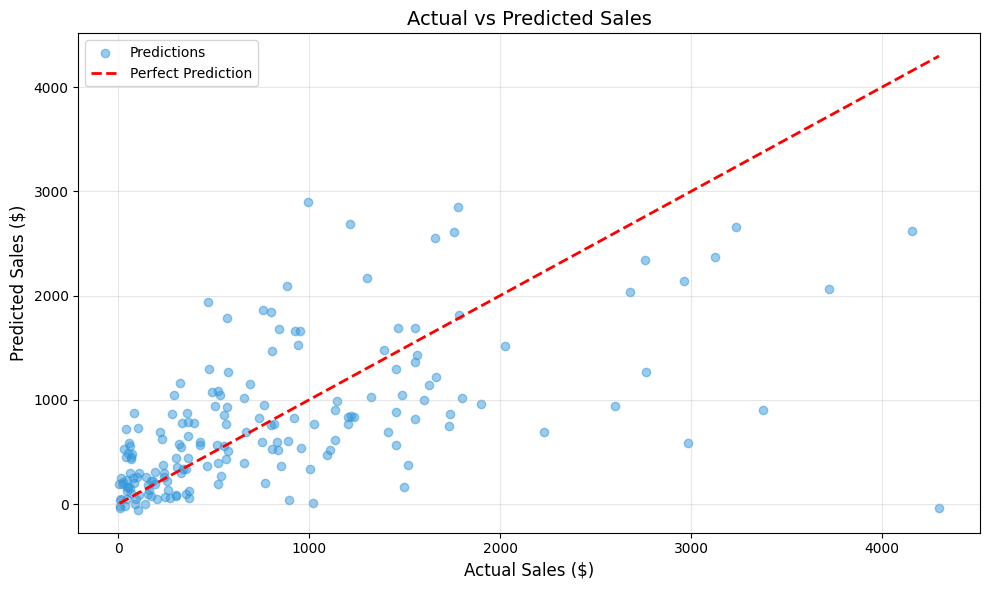

In [122]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='#3498DB', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Sales ($)', fontsize=12)
plt.ylabel('Predicted Sales ($)', fontsize=12)
plt.title('Actual vs Predicted Sales', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### To Calculate residuals (difference between actual and predicted)

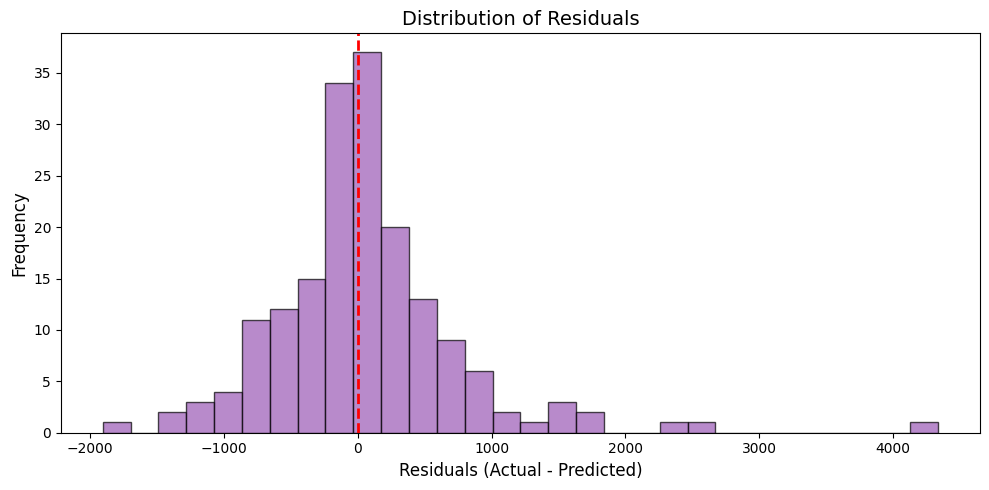

In [123]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='#9B59B6', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14)
plt.tight_layout()
plt.show()

# SALES FORECASTING

In [124]:
# To Create sample future scenarios
future_data = pd.DataFrame({
    'Quantity': [50, 100, 150, 200],
    'Profit': [500, 1200, 2000, 3000],
    'Discount': [0.1, 0.15, 0.2, 0.05],
    'Month': [11, 12, 1, 2],        # Nov, Dec, Jan, Feb
    'Day': [15, 20, 10, 25],
    'DayOfWeek': [3, 4, 0, 1]       # Wed, Thu, Mon, Tue
})

future_predictions = model.predict(future_data)

print("\nFuture Sales Predictions:")
print("-" * 50)
for i, pred in enumerate(future_predictions):
    print(f"   Scenario {i+1}: ${pred:,.2f}")

# Add predictions to dataframe
future_data['Predicted_Sales'] = future_predictions
print("\nComplete Prediction Table:")
print(future_data)


Future Sales Predictions:
--------------------------------------------------
   Scenario 1: $5,313.01
   Scenario 2: $10,872.47
   Scenario 3: $16,436.16
   Scenario 4: $22,197.27

Complete Prediction Table:
   Quantity  Profit  Discount  Month  Day  DayOfWeek  Predicted_Sales
0        50     500      0.10     11   15          3      5313.005206
1       100    1200      0.15     12   20          4     10872.466505
2       150    2000      0.20      1   10          0     16436.156143
3       200    3000      0.05      2   25          1     22197.271223


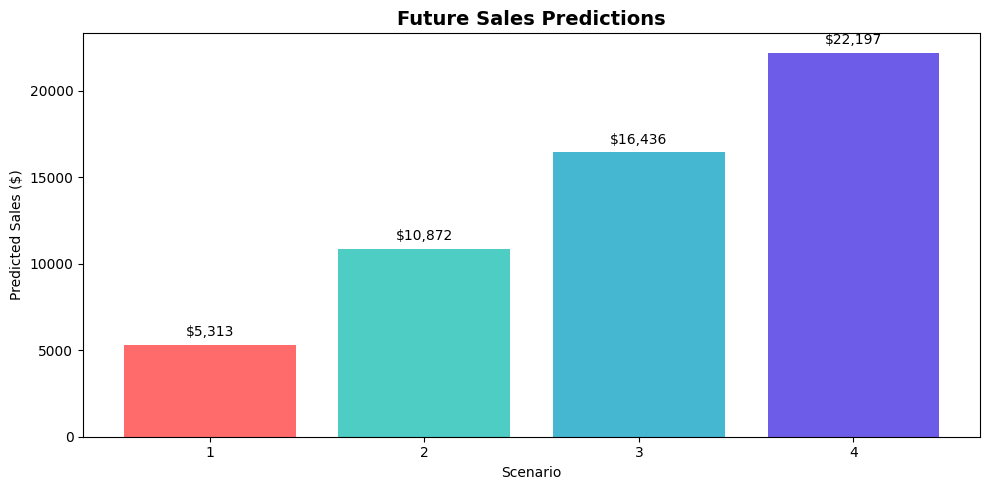

In [125]:
# To Visualize predictions
plt.figure(figsize=(10, 5))
plt.bar(range(1, 5), future_predictions, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#6C5CE7'])
plt.xlabel('Scenario')
plt.ylabel('Predicted Sales ($)')
plt.title('Future Sales Predictions', fontsize=14, fontweight='bold')
plt.xticks(range(1, 5))
for i, v in enumerate(future_predictions):
    plt.text(i+1, v + 500, f"${v:,.0f}", ha='center')
plt.tight_layout()
plt.show()

In [126]:
# To Create predictions for next 30 days
future_30_days = pd.DataFrame({
    'Quantity': [80] * 30,
    'Profit': [800] * 30,
    'Discount': [0.1] * 30,
    'Month': [12] * 30,
    'Day': range(1, 31),
    'DayOfWeek': [i % 7 for i in range(30)]
})

predictions_30_days = model.predict(future_30_days)

print("30-Day Sales Forecast:")
print(f"   Total Predicted Sales: ${sum(predictions_30_days):,.2f}")
print(f"   Average Daily Sales: ${np.mean(predictions_30_days):,.2f}")

30-Day Sales Forecast:
   Total Predicted Sales: $256,938.26
   Average Daily Sales: $8,564.61


In [127]:
import pickle

with open('sales_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as 'sales_model.pkl'")

Model saved as 'sales_model.pkl'


In [129]:
# Export processed data for dashboard
df_daily.to_csv('daily_sales_data.csv', index=False)
monthly_sales.to_csv('monthly_sales_trend.csv')

# Export summary
summary_data = pd.DataFrame({
    'Metric': ['Total Sales', 'Total Profit', 'Total Orders', 'Avg Order Value'],
    'Value': [total_sales, total_profit, total_orders, avg_order_value]
})
summary_data.to_csv('dashboard_summary.csv', index=False)

print(" Data exported for dashboard!")
print("   - daily_sales_data.csv")
print("   - monthly_sales_trend.csv")
print("   - dashboard_summary.csv")

 Data exported for dashboard!
   - daily_sales_data.csv
   - monthly_sales_trend.csv
   - dashboard_summary.csv
